In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Bidirectional, Dense, Activation, Lambda
import csv
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, style="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], style)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

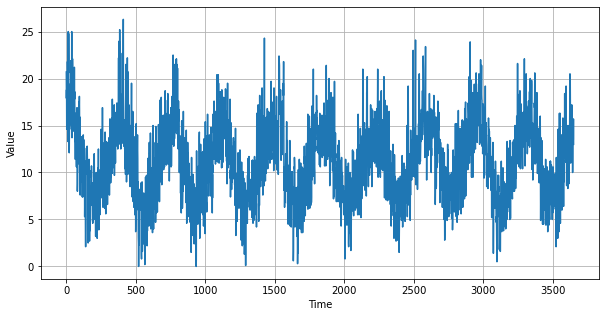

In [3]:
time_steps = []
temperatures = []

with open("daily-min-temperatures.csv") as csvfile:
    csvreader = csv.reader(csvfile, delimiter = ",")
    next(csvreader)
    step = 0
    for row in csvreader:
        temperatures.append(float(row[1]))
        time_steps.append(step)
        step+=1
        
        
series = np.array(temperatures)
time = np.array(time_steps)
plt.figure(figsize=(10,5))
plot_series(time, series)

In [4]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_test = time[split_time:]
x_test = series[split_time:]

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis = -1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda w: (w[:-1], w[1:]))
    return dataset.batch(batch_size).prefetch(1)

In [6]:
def model_forecast(model, series, window_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [7]:
def rnn_model(classes):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', input_shape=[None,1]))
    model.add(Activation('relu'))
    model.add(LSTM(60, return_sequences=True))
    model.add(LSTM(60, return_sequences=True))

    model.add(Dense(30))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('relu'))

    model.add(Dense(classes))
    model.add(Lambda(lambda x: x*400))
    return model

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

tf.keras.backend.clear_session()
tf.random.set_seed(123)
np.random.seed(123)

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = rnn_model(1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 12s 1s/step - loss: 40.3575 - mae: 40.8783
Epoch 2/100
10/10 [==============================] - 4s 449ms/step - loss: 38.9958 - mae: 39.5782
Epoch 3/100
10/10 [==============================] - 4s 448ms/step - loss: 37.0786 - mae: 37.6306
Epoch 4/100
10/10 [==============================] - 5s 458ms/step - loss: 34.7778 - mae: 35.3268
Epoch 5/100
10/10 [==============================] - 5s 470ms/step - loss: 32.1203 - mae: 32.7361
Epoch 6/100
10/10 [==============================] - 4s 449ms/step - loss: 29.1733 - mae: 29.8206
Epoch 7/100
10/10 [==============================] - 4s 445ms/step - loss: 25.8868 - mae: 26.4674
Epoch 8/100
10/10 [==============================] - 4s 445ms/step - loss: 21.9502 - mae: 22.5693
Epoch 9/100
10/10 [==============================] - 4s 444ms/step - loss: 17.4205 - mae: 18.0174
Epoch 10/100
10/10 [==============================] - 5s 452ms/step - loss: 12.2882 - mae: 12.9050
Epoch 11/100
10/10 [=

(1e-08, 0.0001, 0.0, 40.0)

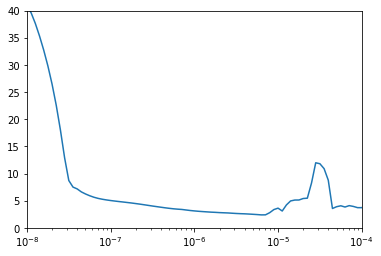

In [9]:
plt.semilogx(history.history["lr"], history.history["mae"])
plt.axis([1e-8, 1e-4, 0, 40])

In [10]:
model = rnn_model(1)
optimizer = tf.keras.optimizers.SGD(lr=8*1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100)

Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 3.8823 - mae: 4.3881
Epoch 2/100
10/10 [==============================] - 4s 436ms/step - loss: 2.6472 - mae: 3.1226
Epoch 3/100
10/10 [==============================] - 4s 435ms/step - loss: 2.3219 - mae: 2.7863
Epoch 4/100
10/10 [==============================] - 5s 463ms/step - loss: 2.1295 - mae: 2.5946
Epoch 5/100
10/10 [==============================] - 4s 432ms/step - loss: 2.0360 - mae: 2.4950
Epoch 6/100
10/10 [==============================] - 5s 454ms/step - loss: 1.9807 - mae: 2.4391
Epoch 7/100
10/10 [==============================] - 4s 441ms/step - loss: 1.9560 - mae: 2.4123
Epoch 8/100
10/10 [==============================] - 4s 448ms/step - loss: 1.9300 - mae: 2.3873
Epoch 9/100
10/10 [==============================] - 4s 448ms/step - loss: 1.9121 - mae: 2.3673
Epoch 10/100
10/10 [==============================] - 5s 463ms/step - loss: 1.8980 - mae: 2.3521
Epoch 11/100
10/10 [=====================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

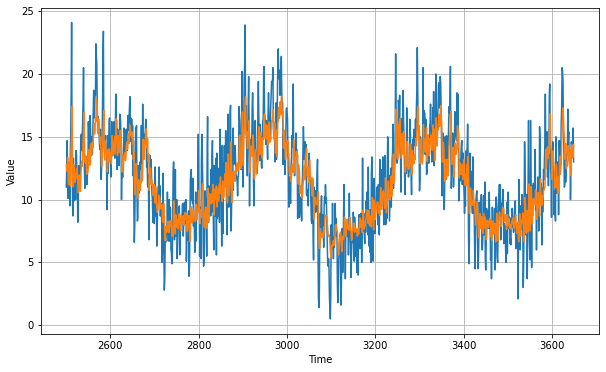

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)
#plt.axis([3400, 3600, 0, 25])

In [13]:
tf.keras.metrics.mean_absolute_error(x_test, rnn_forecast).numpy()

1.8509505

In [14]:
print(rnn_forecast)

[12.737478 12.370595 12.265888 ... 13.308159 13.368326 14.379482]
